Stock Price Prediction
The whole work will be split into two parts:
1. Making prediction to stock price using LSTM neural network
2. Building a dashboard using plotly dash for stock analysis

In [ ]:
"""
1. Imports
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
"""
2. Read the dataset
two datasets will be used in this project
(1) NSE TATA GLOBALl dataset, which is a dataset of Tata Beverages from Tata Gloabal Beverages Limited,
National Stock Exchange of India
(2) Stock dataset with multiple stocks like Apple, Microsoft, and Facebook
"""
nse_tata = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
nse_tata.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [ ]:
"""
3. Making analysis to closing prices from dataframe
"""
# Changing the date format of the data attribute to make it is sorted in the order of year-month-day
nse_tata["Date"] = pd.to_datetime(nse_tata["Date"], format="%Y-%m-%d")
nse_tata.index = nse_tata["Date"]
nse_tata.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-10-08,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


Text(0.5, 1.0, 'Closing Price History')

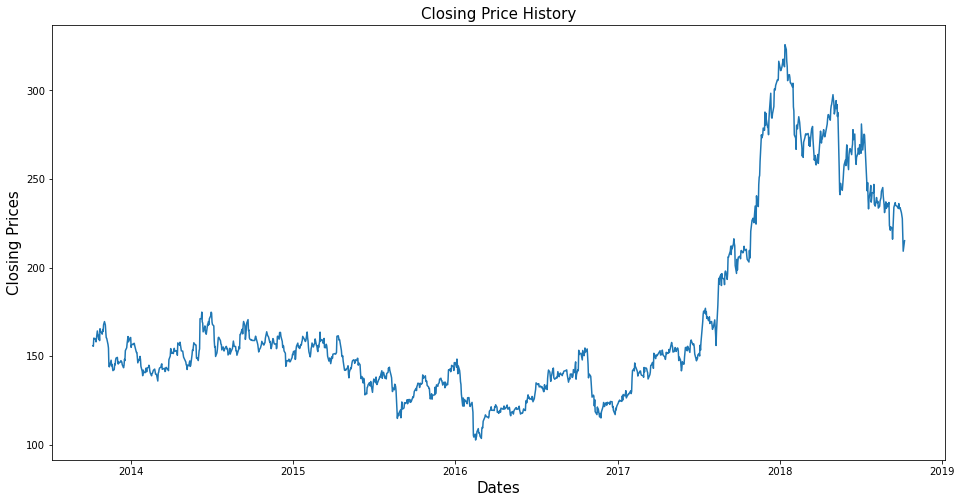

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(nse_tata["Close"], label="Closing Price History")
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Closing Prices', fontsize=15)
plt.title('Closing Price History', fontsize=15)

In [ ]:
"""
4. Sort the dataset on date time and filter "Date" and "Close" columns
"""
# sorting the date attribute in the ascending order
sorted_data = nse_tata.sort_index(ascending=True, axis=0)
# creating a new dataframe only contains two attributes of the original frame ("Date" and "Close")
new_dataset = pd.DataFrame(index=range(0, len(nse_tata)), columns=['Date', 'Close'])

for i in range(0, len(nse_tata)):
    new_dataset['Date'][i] = sorted_data['Date'][i]
    new_dataset['Close'][i] = sorted_data['Close'][i]
print(new_dataset.head())

"""
5. Normalize the new filtered dataset
"""
# Use data coming from the column 'Date' as the index column, making sure it plotted out in the figure
new_dataset.index = new_dataset.Date
# Drop the column "Date" in the new dataset, the missing values will be filled out
new_dataset.drop("Date", axis=1, inplace=True)

# Take values of new_dataset as the final dataset used for training
final_dataset = new_dataset.values

# Use the first 987 out of 1235 instances as the training dataset, 
# the rest is used as the validation dataset
train_data = final_dataset[0:987, :]
valid_data = final_dataset[987:, :]

# Use min-max scaling to do the normalization to the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

# Build the training dataset and testing dataset
x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    # for each instance, every 60 previous records as the inputs of LSTM network, 
    # the instance itself is used as prediction results
    x_train_data.append(scaled_data[i-60:i, 0])  
    y_train_data.append(scaled_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

                  Date   Close
0  2013-10-08 00:00:00   155.8
1  2013-10-09 00:00:00  155.55
2  2013-10-10 00:00:00  160.15
3  2013-10-11 00:00:00  160.05
4  2013-10-14 00:00:00  159.45


In [ ]:
# the total number of instances: 1235
len(new_dataset)

1235

In [ ]:
"""
6. Build and train the LSTM model
"""
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

# Building testing dataset for making prediction, every 60 instances in the training dataset
# corresponds to 60 testing samples
test_inputs = new_dataset[len(new_dataset)-len(valid_data)-60:].values
test_inputs = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs) # normalization to the test data

# model compliing andl training
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
927/927 - 23s - loss: 0.0013 - 23s/epoch - 25ms/step
Epoch 2/5
927/927 - 20s - loss: 5.1111e-04 - 20s/epoch - 22ms/step
Epoch 3/5
927/927 - 20s - loss: 3.6060e-04 - 20s/epoch - 21ms/step
Epoch 4/5
927/927 - 20s - loss: 3.0002e-04 - 20s/epoch - 21ms/step
Epoch 5/5
927/927 - 20s - loss: 2.6804e-04 - 20s/epoch - 21ms/step


In [ ]:
"""
7. Take a sample of a dataset to make stock price predictions using the LSTM model
"""
# Put all testing samples into a list
X_test = []
for i in range(60, test_inputs.shape[0]):
    X_test.append(test_inputs[i-60:i, 0])
X_test = np.array(X_test)

# Add another dimension to the testing data for inputs of CNN
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_closing_price = lstm_model.predict(X_test)
# Perform anti-normalization operation to prediction results
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [ ]:
# Save the LSTM model
lstm_model.save("lstm_model.h5")

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_11732/594068944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_closing_price


Text(0.5, 1.0, 'Closing Price History and Predictions')

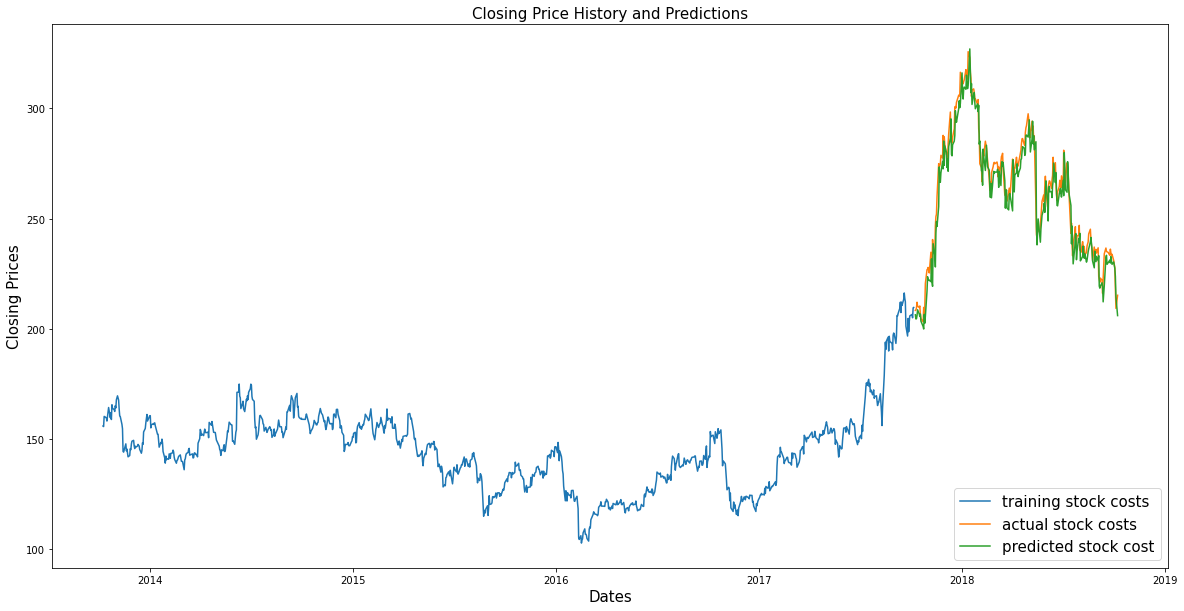

In [ ]:
# Using actual stock costs to visualize the predicted stock costs
train_data = new_dataset[:987]
valid_data = new_dataset[987:]
valid_data['Predictions'] = predicted_closing_price
train_close, = plt.plot(train_data["Close"])
valid_close, = plt.plot(valid_data[["Close"]])
valid_predictions, = plt.plot(valid_data[["Predictions"]])
plt.legend([train_close, valid_close, valid_predictions],
           ['training stock costs', 'actual stock costs', 'predicted stock cost'], loc='lower right', fontsize=15)
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Closing Prices', fontsize=15)
plt.title('Closing Price History and Predictions', fontsize=15)